In [1]:
%load_ext autoreload
%autoreload 2

import os 
# Set the environment for R
if os.environ.get('HOME') == '/home/tom':                                           # Linux
    os.environ['R_HOME'] = '/home/tom/miniconda3/envs/octagon_analysis/lib/R'           # Lab desktop

elif os.environ.get('HOME') is None:                                                # Windows
    if os.environ.get('USERPROFILE') == r'C:\Users\tomha':
        os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'  # Laptop
    elif os.environ.get('USERPROFILE') == r'C:\Users\Tom':
        os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'     # Home desktop
# elif:
    # append other machines here


import rpy2

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility
from ipywidgets import IntProgress
from IPython.display import display
import time
from pymer4.    models import Lmer


[1] "R version 4.1.3 (2022-03-10)"



In [2]:
os.getcwd()

'd:\\Tom\\Documents\\SWC\\repos\\octagon_analysis\\sandbox\\glm'

## Solos

In [10]:
# load solo data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall-bobyqa')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solo_') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[-1], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[3], CV_dataset_names[2]]
ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[3], CV_dataset_names[1], CV_dataset_names[2], CV_dataset_names[4] ]
# ordered_datasets_names = [CV_dataset_names[-4], CV_dataset_names[2], CV_dataset_names[1], CV_dataset_names[0], CV_dataset_names[-1]]
# ordered_datasets_names = CV_dataset_names
ordered_datasets_names =['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle',
                         '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distancesinteraction.pickle',
                         '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_onlydistance.pickle']
['20-fold-CV_results_solo_randomintercepts_onlydistance.pickle', '20-fold-CV_results_solo_randomintercepts_distancepluswallsep.pickle', '20-fold-CV_results_solo_randomintercepts.pickle', '20-fold-CV_results_solo_randomintercepts_distancesinteraction.pickle', '20-fold-CV_results_solo_randomintercepts_distancesandwallsepinteraction.pickle']


In [11]:
cross_validation_datasets[3]['model_formula']

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)'

In [325]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [326]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5'
]

# create plotting names
plotting_names = [
    'distances',
    '+ wall separation',
    '+ first seen wall',
    '+ dist-fsw interactions',
    '+ wallsep-fsw interactions'
]




In [327]:
np.array(cross_validation_datasets[0]['predictions'][0]).size

278

In [328]:
cross_validation_datasets[0].keys()

dict_keys(['name', 'model_formula', 'split_df', 'num_folds', 'predictions', 'predict_data', 'fold_likelihoods', 'fold_nlls', 'fold_avg_nlls', 'average_nll'])

In [329]:
cross_validation_datasets[0]['fold_nlls'][0].size

278

In [330]:
avg_model_likelihoods = [np.nanmean(np.concatenate(cross_validation_datasets[i]['fold_likelihoods'])) for i in range(len(cross_validation_datasets))]

In [331]:
cross_validation_datasets[0]['fold_likelihoods'][0][0:20]

array([0.97308135, 0.87946703, 0.9809157 , 0.74933264, 0.93447721,
       0.94993642, 0.77978854, 0.85808209, 0.81399308, 0.8547537 ,
       0.24577008, 0.84878819, 0.75977748, 0.96562218, 0.72071639,
       0.93195557, 0.95768016, 0.63253511, 0.8032667 , 0.93490704])

In [332]:
# extract and process nll
fold_avg_nlls = [ dataset['fold_avg_nlls'] for dataset in cross_validation_datasets]
fold_all_nlls = [ dataset['fold_nlls'] for dataset in cross_validation_datasets]

# extract and process predictions
all_predictions = []
for dataset in cross_validation_datasets:
    concatenated = np.concatenate([
            np.array(dataset['predictions'][i])
            for i in range(len(dataset['predictions']))
        
        ])
    all_predictions.append(concatenated)

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

In [333]:
concatenated_sizes = [
    np.concatenate(fold_all_nlls[i]).size
    for i in range(len(fold_all_nlls))
]
concatenated_sizes

[5544, 5544, 5436, 5436, 5436]

In [334]:
[model['model_formula'] for model in cross_validation_datasets]

['ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)',
 'ChooseHigh ~ 1 + D2H + D2L + WallSep + (1|GlmPlayerID)',
 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)',
 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)',
 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1|GlmPlayerID)']

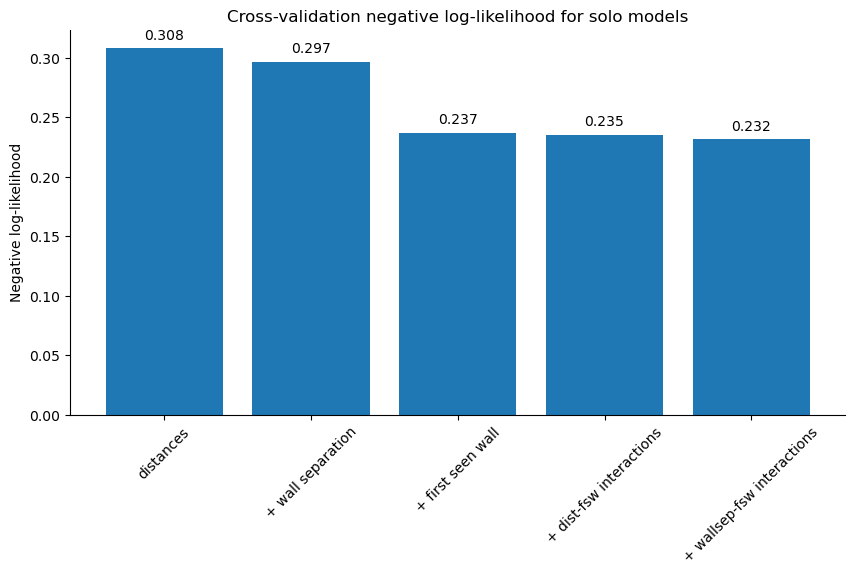

In [335]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [336]:
from scipy.stats import ttest_rel
from itertools import combinations

# Get all pairwise combinations of indices
pairs = list(combinations(range(len(fold_avg_nlls)), 2))
num_comparisons = len(pairs)
print(f"Number of pairwise comparisons: {num_comparisons}")

# Bonferroni-corrected significance level
alpha = 0.05 / num_comparisons

# Run paired t-tests and report results
results = []
for i, j in pairs:
    t_stat, p_val = ttest_rel(fold_avg_nlls[i], fold_avg_nlls[j])
    significant = p_val < alpha
    results.append((i, j, t_stat, p_val, significant))
    print(f"Model {i+1} vs Model {j+1}: t = {t_stat:.3f}, p = {p_val:.4f}, significant (Bonferroni) = {significant}")

print(f"Bonferroni-corrected significance level: {alpha:.4f}")

Number of pairwise comparisons: 10
Model 1 vs Model 2: t = 5.992, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 3: t = 14.179, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 4: t = 14.406, p = 0.0000, significant (Bonferroni) = True
Model 1 vs Model 5: t = 15.174, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 3: t = 12.796, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 4: t = 12.672, p = 0.0000, significant (Bonferroni) = True
Model 2 vs Model 5: t = 12.979, p = 0.0000, significant (Bonferroni) = True
Model 3 vs Model 4: t = 1.593, p = 0.1275, significant (Bonferroni) = False
Model 3 vs Model 5: t = 2.873, p = 0.0097, significant (Bonferroni) = False
Model 4 vs Model 5: t = 2.995, p = 0.0074, significant (Bonferroni) = False
Bonferroni-corrected significance level: 0.0050


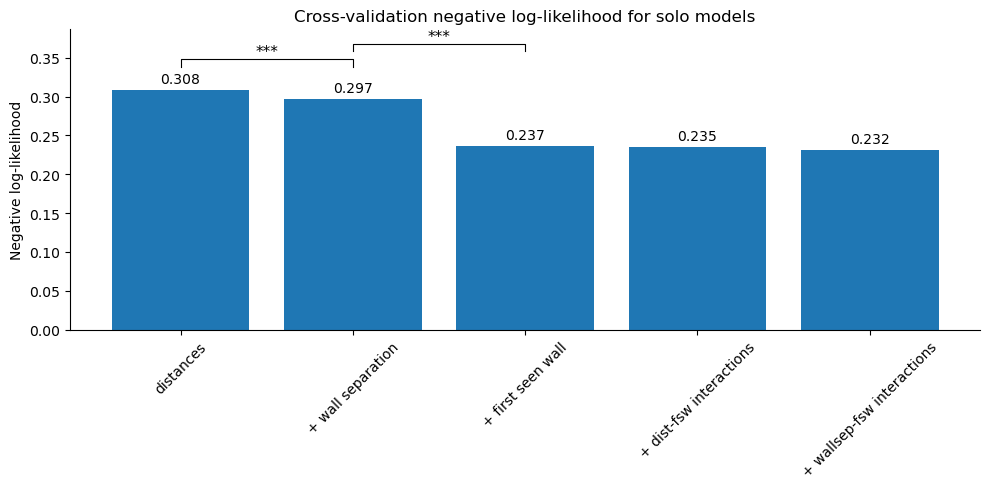

In [337]:
# Plot bar chart of average_nlls with significance markers for only the smallest significant difference per model

# Define significant_pairs: pairs where the Bonferroni-corrected test is significant
significant_pairs = [pair for pair, res in zip(pairs, results) if res[4]]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')

plt.title('Cross-validation negative log-likelihood for solo models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# Mark only the smallest significant difference for each model (compared to models with lower nll)
y_max = max(average_nlls)
h = 0.01  # height of significance lines
vspace = 0.02  # increased vertical spacing between significance bars

# For each model, find the smallest significant difference to a model with lower nll
shown_pairs = set()
for i in range(len(average_nlls)):
    # Only consider comparisons to models with lower nll
    lower_models = [j for j in range(len(average_nlls)) if average_nlls[j] < average_nlls[i]]
    min_diff = None
    min_j = None
    min_p = None
    for j in lower_models:
        # Check if (i, j) or (j, i) is a significant pair
        if (i, j) in significant_pairs:
            res_idx = pairs.index((i, j))
            diff = average_nlls[i] - average_nlls[j]
            if min_diff is None or diff < min_diff:
                min_diff = diff
                min_j = j
                min_p = results[res_idx][3]
        elif (j, i) in significant_pairs:
            res_idx = pairs.index((j, i))
            diff = average_nlls[i] - average_nlls[j]
            if min_diff is None or diff < min_diff:
                min_diff = diff
                min_j = j
                min_p = results[res_idx][3]
    if min_j is not None and (min_j, i) not in shown_pairs and (i, min_j) not in shown_pairs:
        # Determine asterisk level
        if min_p < alpha / 100:
            stars = '***'
        elif min_p < alpha / 10:
            stars = '**'
        else:
            stars = '*'
        x1, x2 = i, min_j
        y = y_max + h + 0.02 + len(shown_pairs) * vspace
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=0.8, c='k')
        plt.text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='k', fontsize=11)
        shown_pairs.add((i, min_j))
plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import ttest_rel
from itertools import combinations, permutations
from scipy.stats import chi2

def plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2):
    """
    Plots two subplots:
    1. Barplot of average_nlls.
    2. Barplot of average_nlls with significance markers for smallest significant difference per model.
    """
    import matplotlib.pyplot as plt

    # First subplot: plain barplot
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs[0].bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
    axs[0].set_ylabel('Average negative log-likelihood')
    axs[0].set_title(title1)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    for i, value in enumerate(average_nlls):
        axs[0].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Second subplot: with significance markers
    bars = axs[1].bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
    axs[1].set_ylabel('Average negative log-likelihood')
    axs[1].set_title(title2)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    for i, value in enumerate(average_nlls):
        axs[1].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    if any(len(name) > 18 for name in plotting_names):
        plt.xticks(rotation=45)

    # Add significance markers
    significant_pairs = [pair for pair, res in zip(pairs, results) if res[4]]
    y_max = max(average_nlls)
    h = 0.02
    vspace = 0.05
    shown_pairs = set()
    for i in range(len(average_nlls)):
        lower_models = [j for j in range(len(average_nlls)) if average_nlls[j] < average_nlls[i]]
        min_diff = None
        min_j = None
        min_p = None
        for j in lower_models:
            if (i, j) in significant_pairs:
                res_idx = pairs.index((i, j))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
            elif (j, i) in significant_pairs:
                res_idx = pairs.index((j, i))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
        if min_j is not None and (min_j, i) not in shown_pairs and (i, min_j) not in shown_pairs:
            if min_p < bonferroni_alpha / 100:
                stars = '***'
            elif min_p < bonferroni_alpha / 10:
                stars = '**'
            else:
                stars = '*'
            x1, x2 = i, min_j
            y = y_max + h + 0.02 + len(shown_pairs) * vspace
            axs[1].plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=0.8, c='k')
            axs[1].text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='k', fontsize=11)
            shown_pairs.add((i, min_j))
    plt.tight_layout()
    plt.show()


def plot_likelihoods_with_significance(average_likelihoods, average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2):
    """
    Plots two subplots:
    1. Barplot of average_likelihoods.
    2. Barplot of average_likelihoods with significance markers for smallest significant difference per model.
    """
    import matplotlib.pyplot as plt

    # First subplot: plain barplot
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    axs[0].bar(range(len(average_likelihoods)), average_likelihoods, tick_label=plotting_names)
    axs[0].set_ylabel('Average likelihood')
    axs[0].set_title(title1)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    for i, value in enumerate(average_likelihoods):
        axs[0].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    # Second subplot: with significance markers
    bars = axs[1].bar(range(len(average_likelihoods)), average_likelihoods, tick_label=plotting_names)
    axs[1].set_ylabel('Average likelihood')
    axs[1].set_title(title2)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    for i, value in enumerate(average_likelihoods):
        axs[1].text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    if any(len(name) > 18 for name in plotting_names):
        plt.xticks(rotation=45)

    # Add significance markers
    significant_pairs = [pair for pair, res in zip(pairs, results) if res[4]]
    y_max = max(average_likelihoods)
    h = 0.02
    vspace = 0.1
    shown_pairs = set()
    for i in range(len(average_nlls)):
        lower_models = [j for j in range(len(average_nlls)) if average_nlls[j] < average_nlls[i]]
        min_diff = None
        min_j = None
        min_p = None
        for j in lower_models:
            if (i, j) in significant_pairs:
                res_idx = pairs.index((i, j))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
            elif (j, i) in significant_pairs:
                res_idx = pairs.index((j, i))
                diff = average_nlls[i] - average_nlls[j]
                if min_diff is None or diff < min_diff:
                    min_diff = diff
                    min_j = j
                    min_p = results[res_idx][3]
        if min_j is not None and (min_j, i) not in shown_pairs and (i, min_j) not in shown_pairs:
            if min_p < bonferroni_alpha / 100:
                stars = '***'
            elif min_p < bonferroni_alpha / 10:
                stars = '**'
            else:
                stars = '*'
            x1, x2 = i, min_j
            y = y_max + h + 0.02 + len(shown_pairs) * vspace
            axs[1].plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=0.8, c='k')
            axs[1].text((x1 + x2) / 2, y + h, stars, ha='center', va='bottom', color='k', fontsize=11)
            shown_pairs.add((i, min_j))
    plt.tight_layout()
    plt.show()

def run_pairwise_ttests(nlls, alpha=0.05):
    """
    Runs all pairwise t-tests between models' nlls and returns results.
    """

    pairs = list(combinations(range(len(nlls)), 2))
    num_comparisons = len(pairs)
    bonferroni_alpha = alpha / num_comparisons

    results = []
    for i, j in pairs:
        print(nlls[i], nlls[j])
        t_stat, p_val = ttest_rel(nlls[i], nlls[j])
        significant = p_val < bonferroni_alpha
        results.append((i, j, t_stat, p_val, significant))
    return results, pairs, bonferroni_alpha

def run_pairwise_lrt(summed_nlls, model_complexities, alpha=0.05):
    """
    Runs all pairwise likelihood ratio tests (LRT) between models' summed NLLs.
    Only compares pairs where model one is more complex than model two.
    Returns results, filtered_pairs, and Bonferroni-corrected alpha.
    """

    # Only consider pairs where model one is more complex than model two
    all_pairs = list(permutations(range(len(summed_nlls)), 2))
    filtered_pairs = [(i, j) for (i, j) in all_pairs if model_complexities[i] > model_complexities[j]]
    print(f"Filtered pairs: {filtered_pairs}")
    num_comparisons = len(filtered_pairs)
    bonferroni_alpha = alpha / num_comparisons if num_comparisons > 0 else alpha

    results = []
    for i, j in filtered_pairs:
        nll_complex = summed_nlls[i]
        nll_simple = summed_nlls[j]
        df_complex = model_complexities[i]
        df_simple = model_complexities[j]

        # LRT statistic
        lr_stat = 2 * (nll_simple - nll_complex)
        dof_diff = int(df_complex - df_simple)
        if dof_diff <= 0:
            p_val = 1.0  # Not a valid comparison
        else:
            p_val = chi2.sf(lr_stat, dof_diff)
        significant = p_val < bonferroni_alpha

        results.append((i, j, lr_stat, p_val, significant))

        # print results
        print(f"Model {i+1} vs Model {j+1}: "
            f"Test statistic = {lr_stat:.3f}, DOF diff = {dof_diff}, p-value = {p_val:.4f}")
    return results, filtered_pairs, bonferroni_alpha

In [339]:
run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)

Filtered pairs: [(0, 1), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)]
Model 1 vs Model 2: Test statistic = 1.730, DOF diff = 1, p-value = 0.1884
Model 3 vs Model 1: Test statistic = 31.113, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 32.843, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 1797.208, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 1798.938, DOF diff = 3, p-value = 0.0000
Model 4 vs Model 3: Test statistic = 1766.095, DOF diff = 1, p-value = 0.0000
Model 5 vs Model 1: Test statistic = 1928.132, DOF diff = 8, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 1929.862, DOF diff = 9, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 1897.019, DOF diff = 7, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 130.923, DOF diff = 6, p-value = 0.0000
Model 6 vs Model 1: Test statistic = 1925.995, DOF diff = 12, p-value = 0.0000
Model 6 vs M

([(0,
   1,
   np.float64(1.7299777355201513),
   np.float64(0.18841374095850838),
   np.False_),
  (2,
   0,
   np.float64(31.112975603546147),
   np.float64(2.4343862286065673e-08),
   np.True_),
  (2,
   1,
   np.float64(32.8429533390663),
   np.float64(7.383177300017244e-08),
   np.True_),
  (3, 0, np.float64(1797.2083147841277), np.float64(0.0), np.True_),
  (3, 1, np.float64(1798.9382925196478), np.float64(0.0), np.True_),
  (3, 2, np.float64(1766.0953391805815), np.float64(0.0), np.True_),
  (4, 0, np.float64(1928.1316941508667), np.float64(0.0), np.True_),
  (4, 1, np.float64(1929.8616718863868), np.float64(0.0), np.True_),
  (4, 2, np.float64(1897.0187185473205), np.float64(0.0), np.True_),
  (4,
   3,
   np.float64(130.92337936673903),
   np.float64(8.21410905059152e-26),
   np.True_),
  (5, 0, np.float64(1925.9949075469572), np.float64(0.0), np.True_),
  (5, 1, np.float64(1927.7248852824773), np.float64(0.0), np.True_),
  (5, 2, np.float64(1894.881931943411), np.float64(0.0)

Filtered pairs: [(0, 1), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)]
Model 1 vs Model 2: Test statistic = 1.730, DOF diff = 1, p-value = 0.1884
Model 3 vs Model 1: Test statistic = 31.113, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 32.843, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 1797.208, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 1798.938, DOF diff = 3, p-value = 0.0000
Model 4 vs Model 3: Test statistic = 1766.095, DOF diff = 1, p-value = 0.0000
Model 5 vs Model 1: Test statistic = 1928.132, DOF diff = 8, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 1929.862, DOF diff = 9, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 1897.019, DOF diff = 7, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 130.923, DOF diff = 6, p-value = 0.0000
Model 6 vs Model 1: Test statistic = 1925.995, DOF diff = 12, p-value = 0.0000
Model 6 vs M

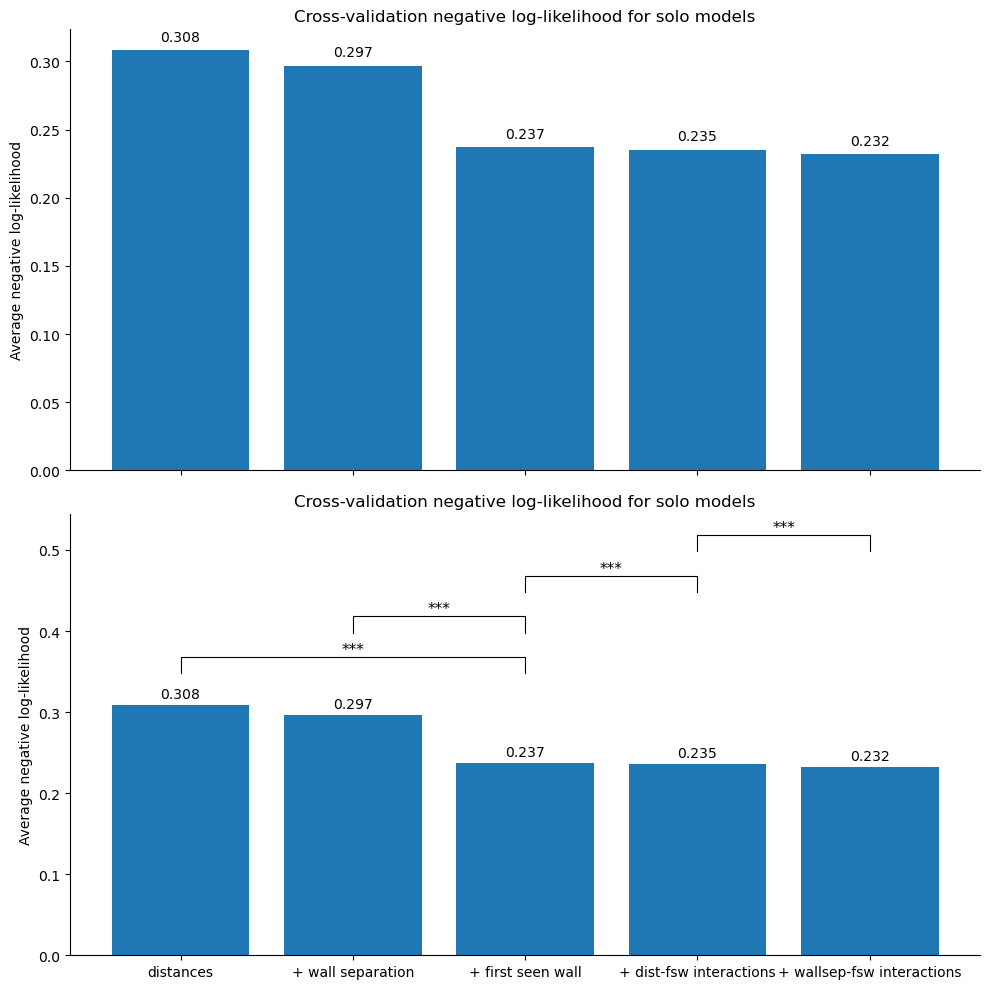

In [340]:
title1 = 'Cross-validation negative log-likelihood for solo models'
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

[0.27669521 0.2954724  0.35201941 0.30506649 0.27903474 0.32706753
 0.33218723 0.29113294 0.29188169 0.33534334 0.26099443 0.31158631
 0.32025261 0.375599   0.2648024  0.28698695 0.28425384 0.32131389
 0.30506027 0.3462938 ] [0.26087165 0.28423616 0.35377616 0.27653002 0.26837163 0.32541909
 0.32327704 0.2828336  0.27219745 0.31628012 0.26477755 0.30044535
 0.2994899  0.35552827 0.25752481 0.26859326 0.28461008 0.30559057
 0.29440382 0.34047009]
[0.27669521 0.2954724  0.35201941 0.30506649 0.27903474 0.32706753
 0.33218723 0.29113294 0.29188169 0.33534334 0.26099443 0.31158631
 0.32025261 0.375599   0.2648024  0.28698695 0.28425384 0.32131389
 0.30506027 0.3462938 ] [0.20285147 0.22639336 0.31756523 0.25114715 0.23648464 0.24298103
 0.26330095 0.21977559 0.24188398 0.2347408  0.22813392 0.23811503
 0.22334582 0.27865346 0.20793963 0.22543467 0.21139702 0.20681983
 0.20859924 0.27345349]
[0.27669521 0.2954724  0.35201941 0.30506649 0.27903474 0.32706753
 0.33218723 0.29113294 0.29188169

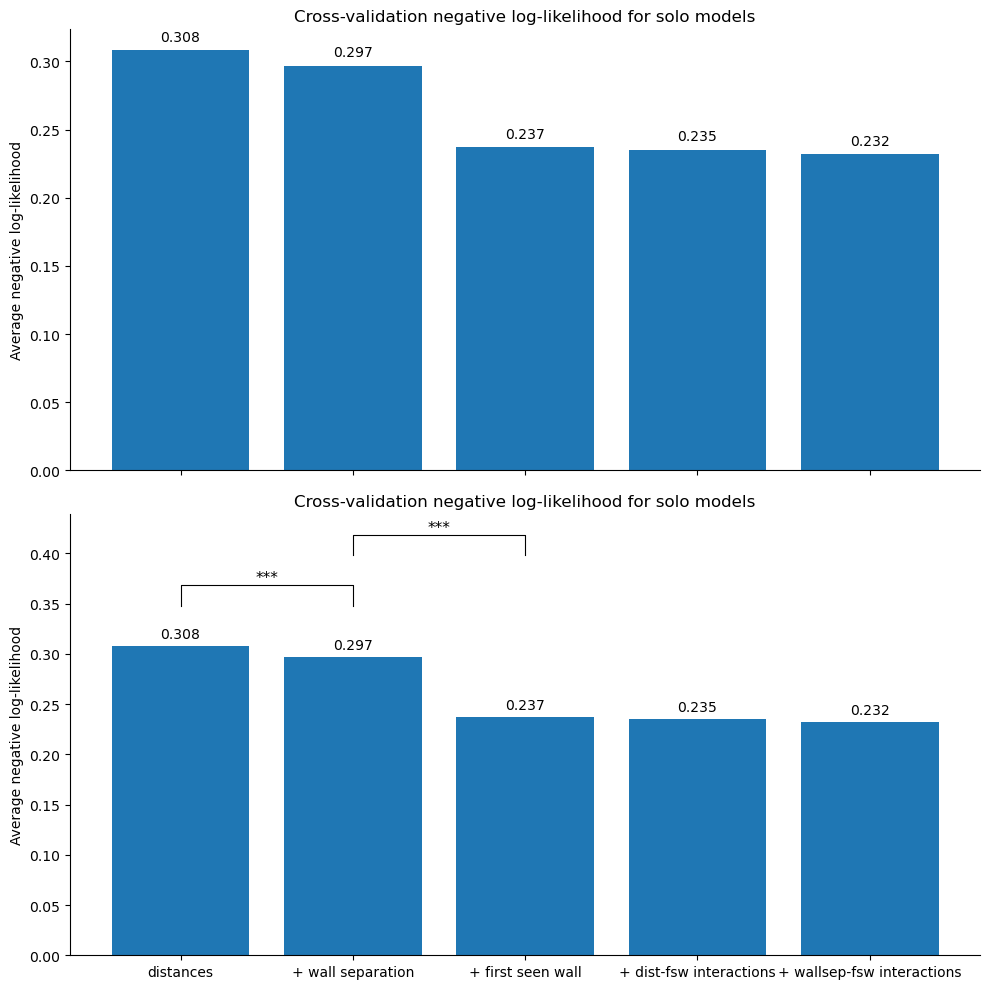

In [341]:
pairs = list(combinations(range(len(average_nlls)), 2))
num_comparisons = len(pairs)
# Bonferroni-corrected significance level
bonferroni_alpha = 0.05 / num_comparisons
title1 = 'Cross-validation negative log-likelihood for solo models'

results, pairs, bonferroni_alpha = run_pairwise_ttests(fold_avg_nlls, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2=title1)

In [342]:
np.array(cross_validation_datasets[3]['predictions'][0]).shape[0], np.array(cross_validation_datasets[3]['predict_data'][0]).shape[0]




(274, 274)

In [343]:
cross_validation_datasets[0]['name']

'solo_randomintercepts_onlydistance'

In [344]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['predict_data'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




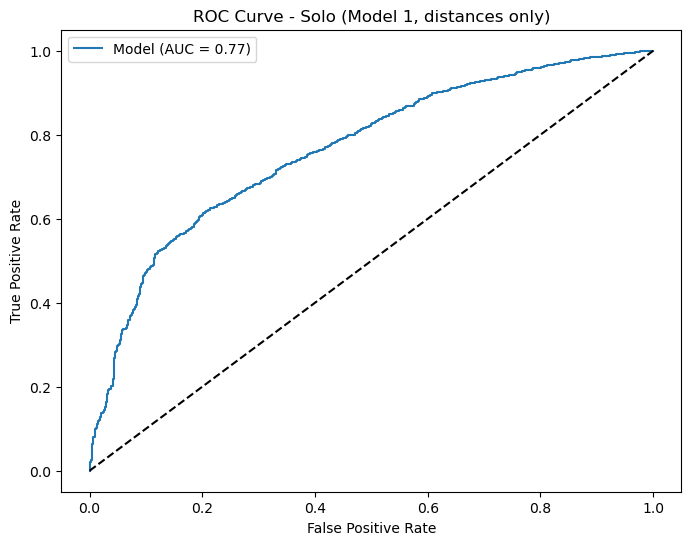

In [345]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[0], prediction_data[0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo (Model 1, distances only)')
plt.legend()
plt.show()

### Testing significance of nlls differences between models

In [346]:
model1 = cross_validation_datasets[-3]
model2 = cross_validation_datasets[-1]

from scipy.stats import ttest_rel
# Perform paired t-test between two models
t_stat, p_value = ttest_rel(model1['fold_avg_nlls'], model2['fold_avg_nlls'])
print(f"Paired t-test between Model 1 and Model 2: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

Paired t-test between Model 1 and Model 2: t-statistic = 2.873, p-value = 0.010


In [347]:
cross_validation_datasets[4]['model_formula']

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1|GlmPlayerID)'

In [348]:
import re
# get list of model parameters for each model
matched_patterns = []

for i in range(len(cross_validation_datasets)):
    matched_patterns_this_model = []
    model_formula = cross_validation_datasets[i]['model_formula']
    pattern_intercept = r'\~\s(\d)'
    pattern_fixed_effects = r'(?<!:)\+\s(\w+)(?!:)'
    pattern_random_intercept = r'\(1\|(\w+)\)'
    pattern_interactions = r'\+\s(\w+:\w+)'
    patterns = [pattern_intercept, pattern_fixed_effects,
                pattern_random_intercept, pattern_interactions]

    for pattern in patterns:
        matches = re.findall(pattern, model_formula)
        for match in matches:
            matched_patterns_this_model.append(match)

    # Print the matched patterns
    print(f"Model {i+1} parameters: {matched_patterns_this_model}")

    # append them to a list
    matched_patterns.append(matched_patterns_this_model)


Model 1 parameters: ['1', 'D2H', 'D2L', 'GlmPlayerID']
Model 2 parameters: ['1', 'D2H', 'D2L', 'WallSep', 'GlmPlayerID']
Model 3 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'GlmPlayerID']
Model 4 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall']
Model 5 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']


In [349]:
# Identify order of complexity of models


model_complexities = np.full(len(matched_patterns), np.nan)
for i in range(len(matched_patterns)):
    # complexity is the number of parameters in the model, plus one extra for each FirstSeenWall term
    # (regardless of whether it is a fixed effect or interaction)
    model_complexity_this_model = len(matched_patterns[i]) + matched_patterns[i].count('FirstSeenWall')
    model_complexities[i] = model_complexity_this_model

# complexity_order = np.argsort(model_complexities)



In [350]:
cross_validation_datasets[0].keys()

dict_keys(['name', 'model_formula', 'split_df', 'num_folds', 'predictions', 'predict_data', 'fold_likelihoods', 'fold_nlls', 'fold_avg_nlls', 'average_nll'])

In [351]:
# parameters for eventual function
model_complexities = model_complexities
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]
folds_all_nlls = [dataset['fold_nlls'] for dataset in cross_validation_datasets]


In [352]:
summed_nlls_per_model = [np.sum(np.concatenate(folds)) for folds in folds_all_nlls]

In [353]:
# identify combinations of models, in correct order of complexity
from itertools import permutations

pairs = list(permutations(range(len(cross_validation_datasets)), 2))
# filter pairs to only include those where the first model is more complex than the second
filtered_pairs = [(i, j) for i, j in pairs if model_complexities[i] > model_complexities[j]]
# print filtered pairs
print("Filtered pairs (more complex model first):")
for i, j in filtered_pairs:
    print(f"Model {i+1} vs Model {j+1}: {model_complexities[i]} vs {model_complexities[j]} (NLL: {summed_nlls_per_model[i]:.3f} vs {summed_nlls_per_model[j]:.3f})")


Filtered pairs (more complex model first):
Model 2 vs Model 1: 5.0 vs 4.0 (NLL: 1645.233 vs 1708.393)
Model 3 vs Model 1: 7.0 vs 4.0 (NLL: 1288.404 vs 1708.393)
Model 3 vs Model 2: 7.0 vs 5.0 (NLL: 1288.404 vs 1645.233)
Model 4 vs Model 1: 11.0 vs 4.0 (NLL: 1279.583 vs 1708.393)
Model 4 vs Model 2: 11.0 vs 5.0 (NLL: 1279.583 vs 1645.233)
Model 4 vs Model 3: 11.0 vs 7.0 (NLL: 1279.583 vs 1288.404)
Model 5 vs Model 1: 13.0 vs 4.0 (NLL: 1260.225 vs 1708.393)
Model 5 vs Model 2: 13.0 vs 5.0 (NLL: 1260.225 vs 1645.233)
Model 5 vs Model 3: 13.0 vs 7.0 (NLL: 1260.225 vs 1288.404)
Model 5 vs Model 4: 13.0 vs 11.0 (NLL: 1260.225 vs 1279.583)


In [354]:
summed_nlls_per_model, model_complexities

([np.float64(1708.3925734922695),
  np.float64(1645.2331839144163),
  np.float64(1288.4035101171144),
  np.float64(1279.5829374893738),
  np.float64(1260.2245936378768)],
 array([ 4.,  5.,  7., 11., 13.]))

In [355]:
filtered_pairs

[(1, 0),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [356]:
summed_nlls_per_model[1]

np.float64(1645.2331839144163)

In [357]:
summed_nlls_per_model

[np.float64(1708.3925734922695),
 np.float64(1645.2331839144163),
 np.float64(1288.4035101171144),
 np.float64(1279.5829374893738),
 np.float64(1260.2245936378768)]

In [358]:
run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)

Filtered pairs: [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3)]
Model 2 vs Model 1: Test statistic = 126.319, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 1: Test statistic = 839.978, DOF diff = 3, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 713.659, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 857.619, DOF diff = 7, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 731.300, DOF diff = 6, p-value = 0.0000
Model 4 vs Model 3: Test statistic = 17.641, DOF diff = 4, p-value = 0.0015
Model 5 vs Model 1: Test statistic = 896.336, DOF diff = 9, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 770.017, DOF diff = 8, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 56.358, DOF diff = 6, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 38.717, DOF diff = 2, p-value = 0.0000


([(1,
   0,
   np.float64(126.31877915570658),
   np.float64(2.6185397508125854e-29),
   np.True_),
  (2,
   0,
   np.float64(839.9781267503104),
   np.float64(9.239691628670031e-182),
   np.True_),
  (2,
   1,
   np.float64(713.6593475946038),
   np.float64(1.073597991875926e-155),
   np.True_),
  (3,
   0,
   np.float64(857.6192720057916),
   np.float64(6.791408743530103e-181),
   np.True_),
  (3,
   1,
   np.float64(731.300492850085),
   np.float64(1.0655967036871624e-154),
   np.True_),
  (3,
   2,
   np.float64(17.641145255481206),
   np.float64(0.0014501428724535178),
   np.True_),
  (4,
   0,
   np.float64(896.3359597087856),
   np.float64(3.8099153834573656e-187),
   np.True_),
  (4,
   1,
   np.float64(770.017180553079),
   np.float64(5.950345387395821e-161),
   np.True_),
  (4,
   2,
   np.float64(56.35783295847523),
   np.float64(2.464167259198393e-10),
   np.True_),
  (4,
   3,
   np.float64(38.71668770299402),
   np.float64(3.915417580534315e-09),
   np.True_)],
 [(1, 0),


In [359]:
from scipy.stats import chi2
# LRT function to compute all LRTs possible for a given set of models

p_vals = np.full(len(filtered_pairs), np.nan)

# loop through filtered pairs and calculate LRTs
for i in range(len(filtered_pairs)):
    nll_full = summed_nlls_per_model[filtered_pairs[i][0]]
    nll_reduced = summed_nlls_per_model[filtered_pairs[i][1]]
    dof_full = model_complexities[filtered_pairs[i][0]]
    dof_reduced = model_complexities[filtered_pairs[i][1]]

    # print(f"Model {filtered_pairs[i][0]+1} vs Model {filtered_pairs[i][1]+1}: "
    #       f"NLL full = {nll_full:.3f}, NLL reduced = {nll_reduced:.3f}, "
    #       f"DOF full = {dof_full}, DOF reduced = {dof_reduced}")

    # calculate test statistic and p-value
    test_stat = 2*(nll_reduced - nll_full)
    dof_diff = dof_full - dof_reduced
    p_val = chi2.sf(test_stat, dof_diff)
    p_vals[i] = p_val

    # print results
    print(f"Model {filtered_pairs[i][0]+1} vs Model {filtered_pairs[i][1]+1}: "
        f"Test statistic = {test_stat:.3f}, DOF diff = {dof_diff}, p-value = {p_val:.4f}")

Model 2 vs Model 1: Test statistic = 126.319, DOF diff = 1.0, p-value = 0.0000
Model 3 vs Model 1: Test statistic = 839.978, DOF diff = 3.0, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 713.659, DOF diff = 2.0, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 857.619, DOF diff = 7.0, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 731.300, DOF diff = 6.0, p-value = 0.0000
Model 4 vs Model 3: Test statistic = 17.641, DOF diff = 4.0, p-value = 0.0015
Model 5 vs Model 1: Test statistic = 896.336, DOF diff = 9.0, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 770.017, DOF diff = 8.0, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 56.358, DOF diff = 6.0, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 38.717, DOF diff = 2.0, p-value = 0.0000


Model 1 parameters: ['1', 'D2H', 'D2L', 'GlmPlayerID']
Model 2 parameters: ['1', 'D2H', 'D2L', 'WallSep', 'GlmPlayerID']
Model 3 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'GlmPlayerID']
Model 4 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall']
Model 5 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Filtered pairs: [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3)]
Model 2 vs Model 1: Test statistic = 126.319, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 1: Test statistic = 839.978, DOF diff = 3, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 713.659, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 857.619, DOF diff = 7, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 731.300, DOF diff = 6, p-value = 0.0000

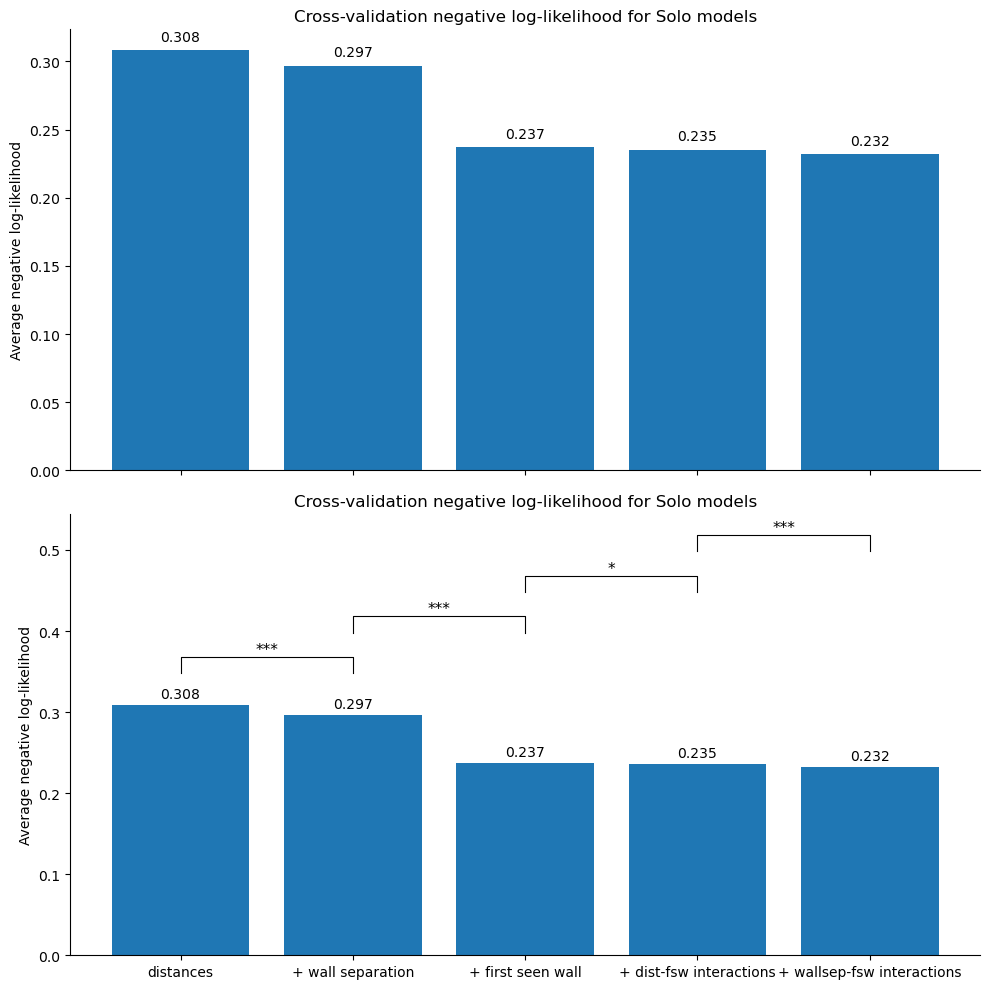

In [360]:
# Identify order of complexity of models

import re
# get list of model parameters for each model
matched_patterns = []

for i in range(len(cross_validation_datasets)):
    matched_patterns_this_model = []
    model_formula = cross_validation_datasets[i]['model_formula']
    pattern_intercept = r'\~\s(\d)'
    pattern_fixed_effects = r'(?<!:)\+\s(\w+)(?!:)'
    pattern_random_intercept = r'\(1\|(\w+)\)'
    pattern_interactions = r'\+\s(\w+:\w+)'
    patterns = [pattern_intercept, pattern_fixed_effects,
                pattern_random_intercept, pattern_interactions]

    for pattern in patterns:
        matches = re.findall(pattern, model_formula)
        for match in matches:
            matched_patterns_this_model.append(match)

    # Print the matched patterns
    print(f"Model {i+1} parameters: {matched_patterns_this_model}")

    # append them to a list
    matched_patterns.append(matched_patterns_this_model)



model_complexities = np.full(len(matched_patterns), np.nan)
for i in range(len(matched_patterns)):
    # complexity is the number of parameters in the model, plus one extra for each FirstSeenWall term
    # (regardless of whether it is a fixed effect or interaction)
    model_complexity_this_model = len(matched_patterns[i]) + matched_patterns[i].count('FirstSeenWall')
    model_complexities[i] = model_complexity_this_model

# complexity_order = np.argsort(model_complexities)

# parameters for eventual function
model_complexities = model_complexities
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]
folds_all_nlls = [dataset['fold_nlls'] for dataset in cross_validation_datasets]

summed_nlls_per_model = [np.sum(np.concatenate(folds)) for folds in folds_all_nlls]

title1 = 'Cross-validation negative log-likelihood for Solo models'
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

Filtered pairs: [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3)]
Model 2 vs Model 1: Test statistic = 126.319, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 1: Test statistic = 839.978, DOF diff = 3, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 713.659, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 857.619, DOF diff = 7, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 731.300, DOF diff = 6, p-value = 0.0000
Model 4 vs Model 3: Test statistic = 17.641, DOF diff = 4, p-value = 0.0015
Model 5 vs Model 1: Test statistic = 896.336, DOF diff = 9, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 770.017, DOF diff = 8, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 56.358, DOF diff = 6, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 38.717, DOF diff = 2, p-value = 0.0000


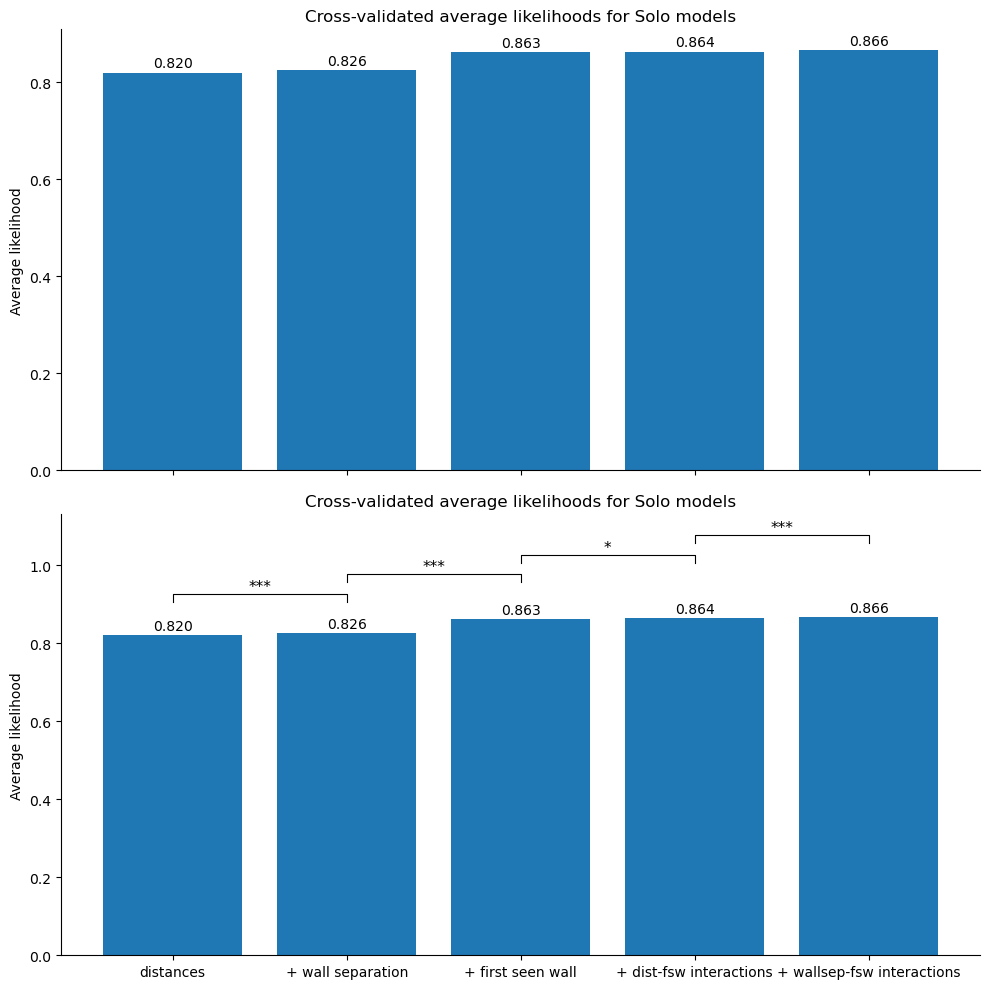

In [361]:
title1 = 'Cross-validated average likelihoods for Solo models'
avg_model_likelihoods = [np.nanmean(np.concatenate(cross_validation_datasets[i]['fold_likelihoods'])) for i in range(len(cross_validation_datasets))]
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_likelihoods_with_significance(avg_model_likelihoods, summed_nlls_per_model, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

## Solo-social

In [43]:
# load solo-social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall-bobyqa')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_solosocial') and file.endswith('.pickle')
]
print(CV_dataset_names)

# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[2], CV_dataset_names[3], CV_dataset_names[4], CV_dataset_names[2]]
# ordered_datasets_names = [CV_dataset_names[-2], CV_dataset_names[-3], CV_dataset_names[-4],  CV_dataset_names[1], CV_dataset_names[0]]
# ordered_datasets_names = ['20-fold-CV_results_solosocial_randomintercepts.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext.pickle',
#                           '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions.pickle',
#                           '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions_socialcontext-dist_interactions.pickle',
#                           '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions_socialcontext-dist-interactions_solo-interactions.pickle']
ordered_datasets_names = ["20-fold-CV_results_solosocial_randomintercepts_bestsolomodel.pickle",
"20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext.pickle",
"20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_SC-FSW-interactions.pickle",
"20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_SC-WS-interactions.pickle",
"20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_allinteractions.pickle"
]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_solosocial_randomintercepts.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_allinteractions.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_SC-dist-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_SC-FSW-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_bestsolomodel_socialcontext_SC-WS-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socialcontext_fsw-interactions_socialcontext-dist-interactions_solo-interactions.pickle', '20-fold-CV_results_solosocial_randomintercepts_plus-socia

In [42]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [44]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5']

# # create plotting names
# plotting_names = [
#     'Solo fixed effects',
#     '+ Social context',
#     '+ SC-FSW interaction',
#     '+ SC-Dist interactions',
#     '+ Solo interactions']

plotting_names = [
    'best Solo model',
    '+ SocialContext',
    '+ SC-FirstSeenWall interactions',
    '+ SC-WallSep interactions',
    '+ SC-distances interactions'
]

In [45]:
cross_validation_datasets[0]['split_df'][0]['FirstSeenWall'].unique()

['2.0', '1.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

In [46]:
len(average_nlls)

3

In [47]:
cross_validation_datasets[1]['model_formula']

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1 |GlmPlayerID) + SocialContext'

Model 1 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 2 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'SocialContext', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 3 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'SocialContext', 'SocialContex', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep', 'SocialContext:FirstSeenWall']
Model 4 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'SocialContext', 'SocialContex', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep', 'SocialContext:WallSep']
Model 5 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'SocialContext', 'SocialContex', 'SocialContex', 'SocialContex', 'SocialContex', 'D2H:FirstSeenWall', 'D2L:FirstS

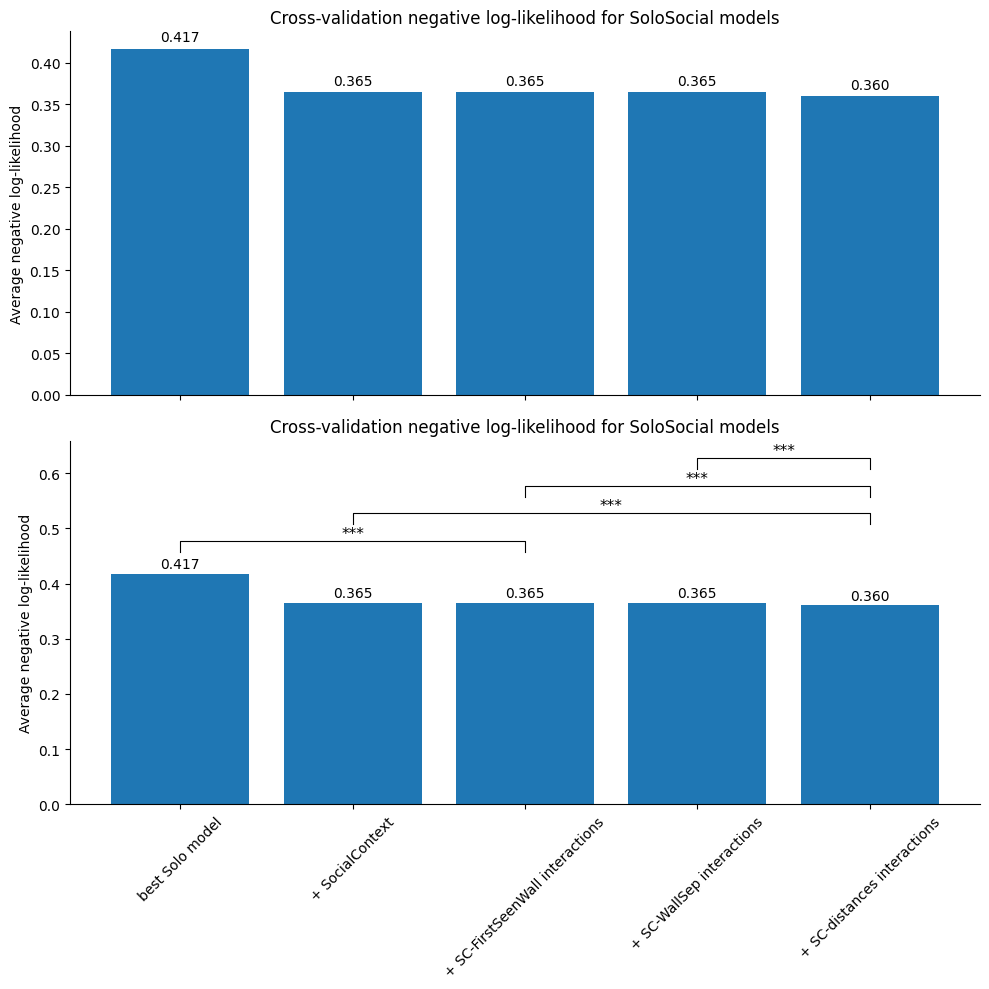

In [48]:
# Identify order of complexity of models

import re
# get list of model parameters for each model
matched_patterns = []

for i in range(len(cross_validation_datasets)):
    matched_patterns_this_model = []
    model_formula = cross_validation_datasets[i]['model_formula']
    pattern_intercept = r'\~\s(\d)'
    pattern_fixed_effects = r'(?<!:)\+\s(\w+)(?!:)'
    pattern_random_intercept = r'\(1\|(\w+)\)'
    pattern_interactions = r'\+\s(\w+:\w+)'
    patterns = [pattern_intercept, pattern_fixed_effects,
                pattern_random_intercept, pattern_interactions]

    for pattern in patterns:
        matches = re.findall(pattern, model_formula)
        for match in matches:
            matched_patterns_this_model.append(match)

    # Print the matched patterns
    print(f"Model {i+1} parameters: {matched_patterns_this_model}")

    # append them to a list
    matched_patterns.append(matched_patterns_this_model)



model_complexities = np.full(len(matched_patterns), np.nan)
for i in range(len(matched_patterns)):
    # complexity is the number of parameters in the model, plus one extra for each FirstSeenWall term
    # (regardless of whether it is a fixed effect or interaction)
    model_complexity_this_model = len(matched_patterns[i]) + matched_patterns[i].count('FirstSeenWall')
    model_complexities[i] = model_complexity_this_model

# complexity_order = np.argsort(model_complexities)

# parameters for eventual function
model_complexities = model_complexities
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]
folds_all_nlls = [dataset['fold_nlls'] for dataset in cross_validation_datasets]

summed_nlls_per_model = [np.sum(np.concatenate(folds)) for folds in folds_all_nlls]

title1 = 'Cross-validation negative log-likelihood for SoloSocial models'
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

In [49]:
# extract and process nll
nlls = [ dataset['fold_nlls'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

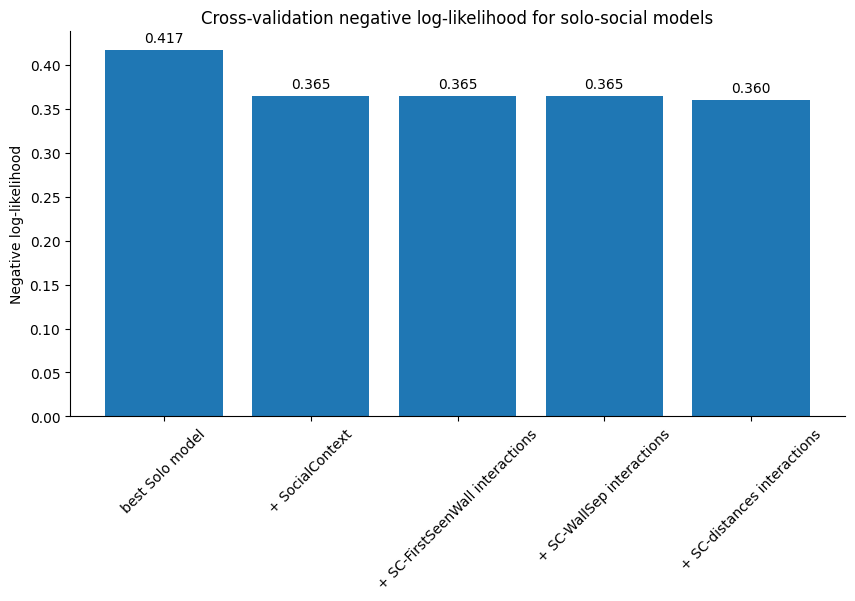

In [50]:
# plot nll barplot

plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for solo-social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [51]:
cross_validation_datasets[0]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + D2H:FirstSeenWall + D2L:FirstSeenWall + FirstSeenWall:WallSep + (1 |GlmPlayerID)'

In [52]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['split_df'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




In [53]:
# pairs = list(combinations(range(len(nlls)), 2))
# num_comparisons = len(pairs)
# # Bonferroni-corrected significance level
# bonferroni_alpha = 0.05 / num_comparisons
# title1 = 'Cross-validation negative log-likelihood for solosocial models'

# results, pairs, bonferroni_alpha = run_pairwise_ttests(nlls, alpha=0.05)
# plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2=title1)

Filtered pairs: [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (4, 2), (4, 3)]
Model 2 vs Model 1: Test statistic = 1211.519, DOF diff = 1, p-value = 0.0000
Model 3 vs Model 1: Test statistic = 1210.210, DOF diff = 3, p-value = 0.0000
Model 3 vs Model 2: Test statistic = -1.309, DOF diff = 2, p-value = 1.0000
Model 4 vs Model 1: Test statistic = 1210.942, DOF diff = 3, p-value = 0.0000
Model 4 vs Model 2: Test statistic = -0.577, DOF diff = 2, p-value = 1.0000
Model 5 vs Model 1: Test statistic = 1316.491, DOF diff = 9, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 104.972, DOF diff = 8, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 106.281, DOF diff = 6, p-value = 0.0000
Model 5 vs Model 4: Test statistic = 105.549, DOF diff = 6, p-value = 0.0000


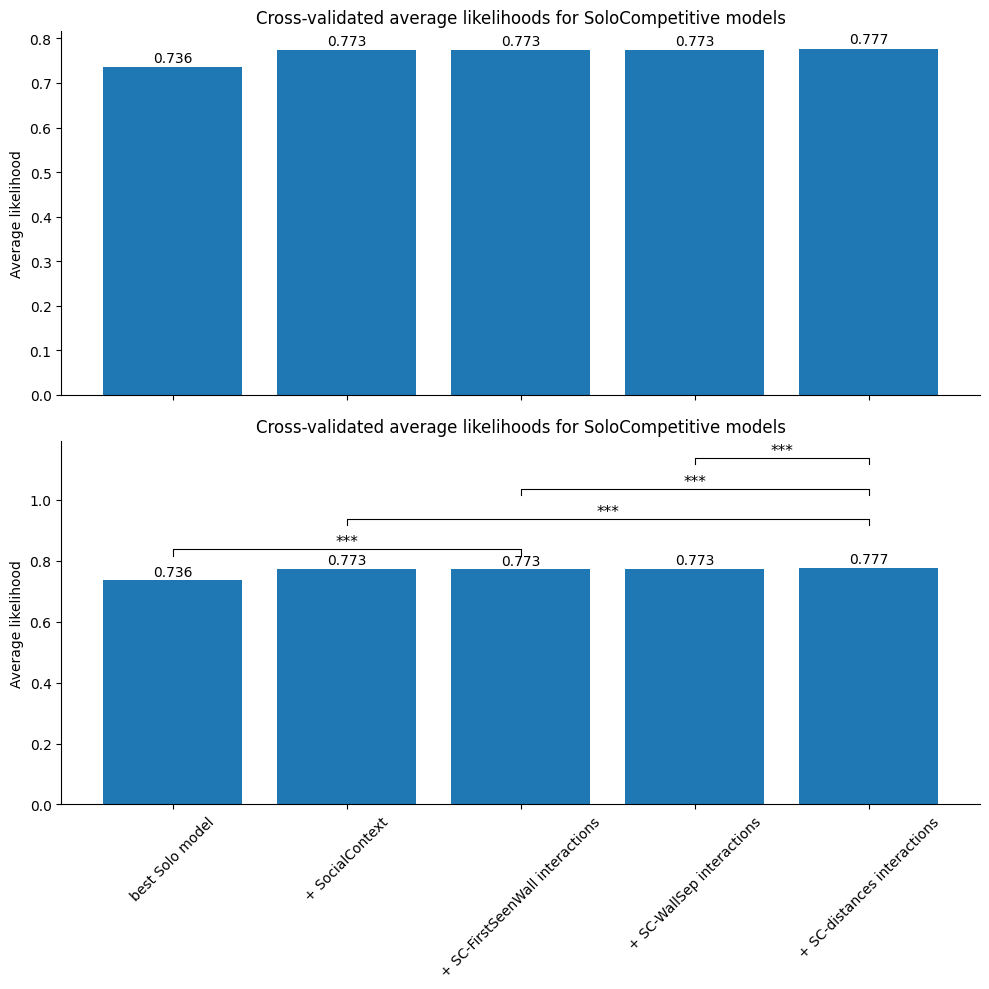

In [54]:
title1 = 'Cross-validated average likelihoods for SoloCompetitive models'
avg_model_likelihoods = [np.nanmean(np.concatenate(cross_validation_datasets[i]['fold_likelihoods'])) for i in range(len(cross_validation_datasets))]
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_likelihoods_with_significance(avg_model_likelihoods, summed_nlls_per_model, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

In [292]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['predict_data'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




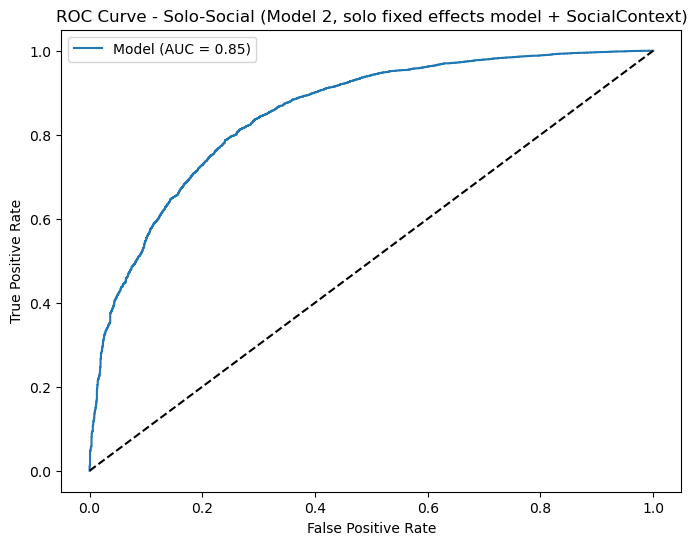

In [293]:
from sklearn.metrics import roc_curve, auc

# remove elements from datasets if ground truth is NaN
for i in range(len(ground_truth_data)):
    mask = ~np.isnan(ground_truth_data[i])
    ground_truth_data[i] = ground_truth_data[i][mask]
    prediction_data[i] = prediction_data[i][mask]

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[1], prediction_data[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Solo-Social (Model 2, solo fixed effects model + SocialContext)') 
plt.legend()
plt.show()

## Social

In [3]:
# load social data from left-one-out cross-validation
data_folder = os.path.join('..','data', 'k_fold_CV', '3levels-firstseenwall-bobyqa')

CV_dataset_names = [
    file for file in os.listdir(data_folder) if file.startswith('20-fold-CV_results_social') and file.endswith('.pickle')
]
print(CV_dataset_names)

ordered_datasets_names = [CV_dataset_names[2], CV_dataset_names[1], CV_dataset_names[3], CV_dataset_names[-1], CV_dataset_names[4], CV_dataset_names[0]]
# ordered_datasets_names = [CV_dataset_names[0], CV_dataset_names[-1], CV_dataset_names[1], CV_dataset_names[2]]
# ordered_datasets_names = ['20-fold-CV_results_social_randomintercepts_opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible.pickle',
#                           '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance.pickle', 
#                           '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen.pickle',
#                           '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solointeractions.pickle',
#                           '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solo-and-social-interactions.pickle']
ordered_datasets_names = ["20-fold-CV_results_social_randomintercepts_bestsolomodel.pickle", 
                        "20-fold-CV_results_social_randomintercepts_bestsolo_opponentvisible.pickle",
                        "20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance.pickle",
                        "20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance_opponentfirstseen.pickle",
                        "20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance_opponentfirstseen_socialdistinteractions.pickle"]


print(ordered_datasets_names)


cross_validation_datasets = [pd.read_pickle(os.path.join(data_folder, file)) for file in ordered_datasets_names
]


['20-fold-CV_results_social_randomintercepts_bestsolomodel.pickle', '20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance.pickle', '20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance_opponentfirstseen.pickle', '20-fold-CV_results_social_randomintercepts_bestsolo_opponentdistance_opponentfirstseen_socialdistinteractions.pickle', '20-fold-CV_results_social_randomintercepts_bestsolo_opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solo-and-social-interactions.pickle', '20-fold-CV_results_social_randomintercepts_no-opponentvisible_opponentdistance_opponentfirstseen_solointeractions.pickle', '20-fold-CV_results_social_ran

In [4]:
# find k
k = len(cross_validation_datasets[0]['split_df'])
print(f"{k} folds")

20 folds


In [10]:
# create plotting names
plotting_names = [
    'model 1',
    'model 2',
    'model 3',
    'model 4',
    'model 5',
    'model 6']


# create plotting names
# plotting_names = [
#     'Solo fixed + opponent visible',
#     'Solo fixed effects',
#     '+ opponent distances',
#     '+ oppponent first seen wall',
#     '+ solo interactions',
#     '+ social interactions']
plotting_names = [
    'best Solo model',
    '+ opponent visibility',
    '+ opponent distances',
    '+ opponent first seen wall',
    '+ player distances interaction']


In [11]:
# extract and process nll
nlls = [ dataset['fold_nlls'] for dataset in cross_validation_datasets]

# divide nll by the number of models
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]

Model 1 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 2 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'OpponentVisible', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 3 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'OpponentD2L', 'OpponentD2H', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 4 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'D2', 'D2', 'FirstSeenWal', 'OpponentD2L', 'OpponentD2H', 'GlmPlayerID', 'D2H:FirstSeenWall', 'D2L:FirstSeenWall', 'FirstSeenWall:WallSep']
Model 5 parameters: ['1', 'D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'FirstSeenWal', 'D2', 'D2', 'OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall', 'D2', 'D2', 'GlmPlayerID', 'FirstSeenWall:WallSep', 'D2H:F

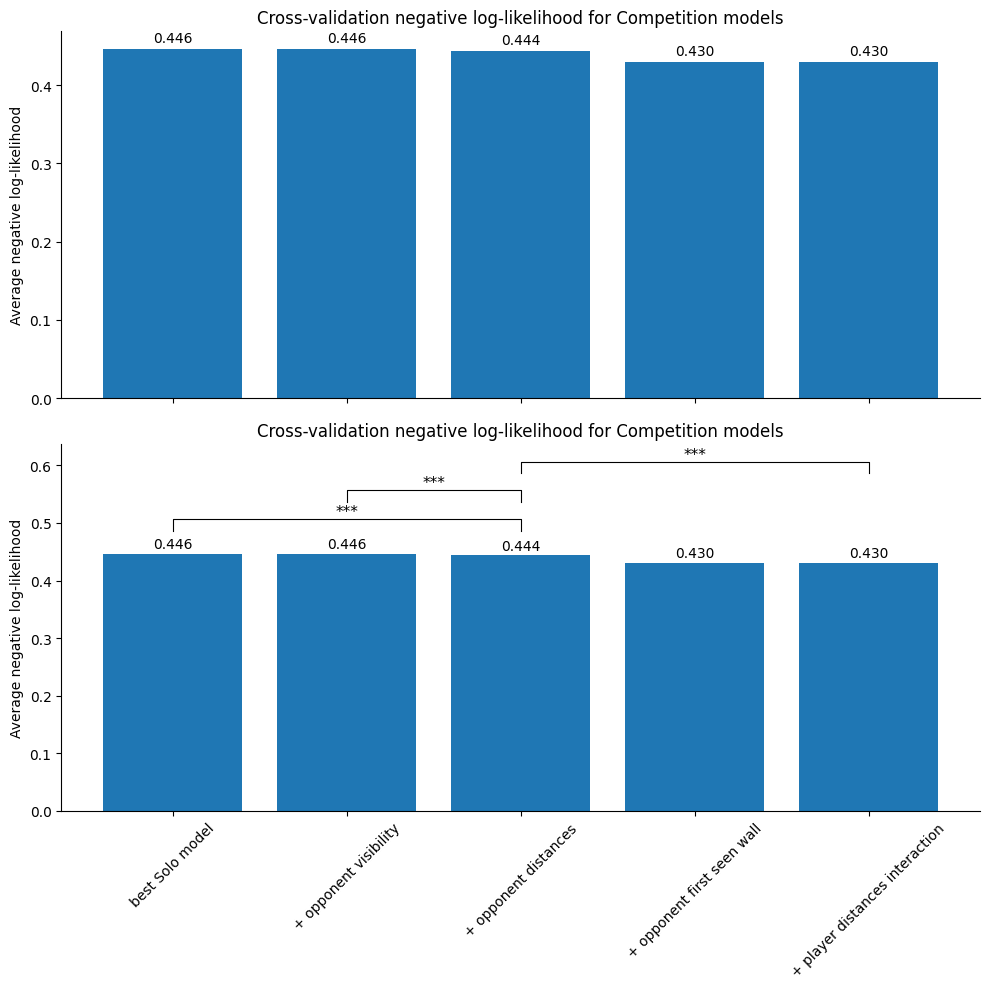

In [14]:
# Identify order of complexity of models

import re
# get list of model parameters for each model
matched_patterns = []

for i in range(len(cross_validation_datasets)):
    matched_patterns_this_model = []
    model_formula = cross_validation_datasets[i]['model_formula']
    pattern_intercept = r'\~\s(\d)'
    pattern_fixed_effects = r'(?<!:)\+\s(\w+)(?!:)'
    pattern_random_intercept = r'\(1\|(\w+)\)'
    pattern_interactions = r'\+\s(\w+:\w+)'
    patterns = [pattern_intercept, pattern_fixed_effects,
                pattern_random_intercept, pattern_interactions]

    for pattern in patterns:
        matches = re.findall(pattern, model_formula)
        for match in matches:
            matched_patterns_this_model.append(match)

    # Print the matched patterns
    print(f"Model {i+1} parameters: {matched_patterns_this_model}")

    # append them to a list
    matched_patterns.append(matched_patterns_this_model)



model_complexities = np.full(len(matched_patterns), np.nan)
for i in range(len(matched_patterns)):
    # complexity is the number of parameters in the model, plus one extra for each FirstSeenWall term
    # (regardless of whether it is a fixed effect or interaction)
    model_complexity_this_model = len(matched_patterns[i]) + matched_patterns[i].count('FirstSeenWall')
    model_complexities[i] = model_complexity_this_model

# complexity_order = np.argsort(model_complexities)

# parameters for eventual function
model_complexities = model_complexities
average_nlls = [dataset['average_nll'] for dataset in cross_validation_datasets]
folds_all_nlls = [dataset['fold_nlls'] for dataset in cross_validation_datasets]

summed_nlls_per_model = [np.sum(np.concatenate(folds)) for folds in folds_all_nlls]

title1 = 'Cross-validation negative log-likelihood for Competition models'
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_nlls_with_significance(average_nlls, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

Filtered pairs: [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (4, 2), (4, 3)]
Model 2 vs Model 1: Test statistic = -0.011, DOF diff = 1, p-value = 1.0000
Model 3 vs Model 1: Test statistic = 35.493, DOF diff = 2, p-value = 0.0000
Model 3 vs Model 2: Test statistic = 35.504, DOF diff = 1, p-value = 0.0000
Model 4 vs Model 1: Test statistic = 1724.070, DOF diff = 2, p-value = 0.0000
Model 4 vs Model 2: Test statistic = 1724.080, DOF diff = 1, p-value = 0.0000
Model 5 vs Model 1: Test statistic = 1721.934, DOF diff = 7, p-value = 0.0000
Model 5 vs Model 2: Test statistic = 1721.944, DOF diff = 6, p-value = 0.0000
Model 5 vs Model 3: Test statistic = 1686.441, DOF diff = 5, p-value = 0.0000
Model 5 vs Model 4: Test statistic = -2.136, DOF diff = 5, p-value = 1.0000


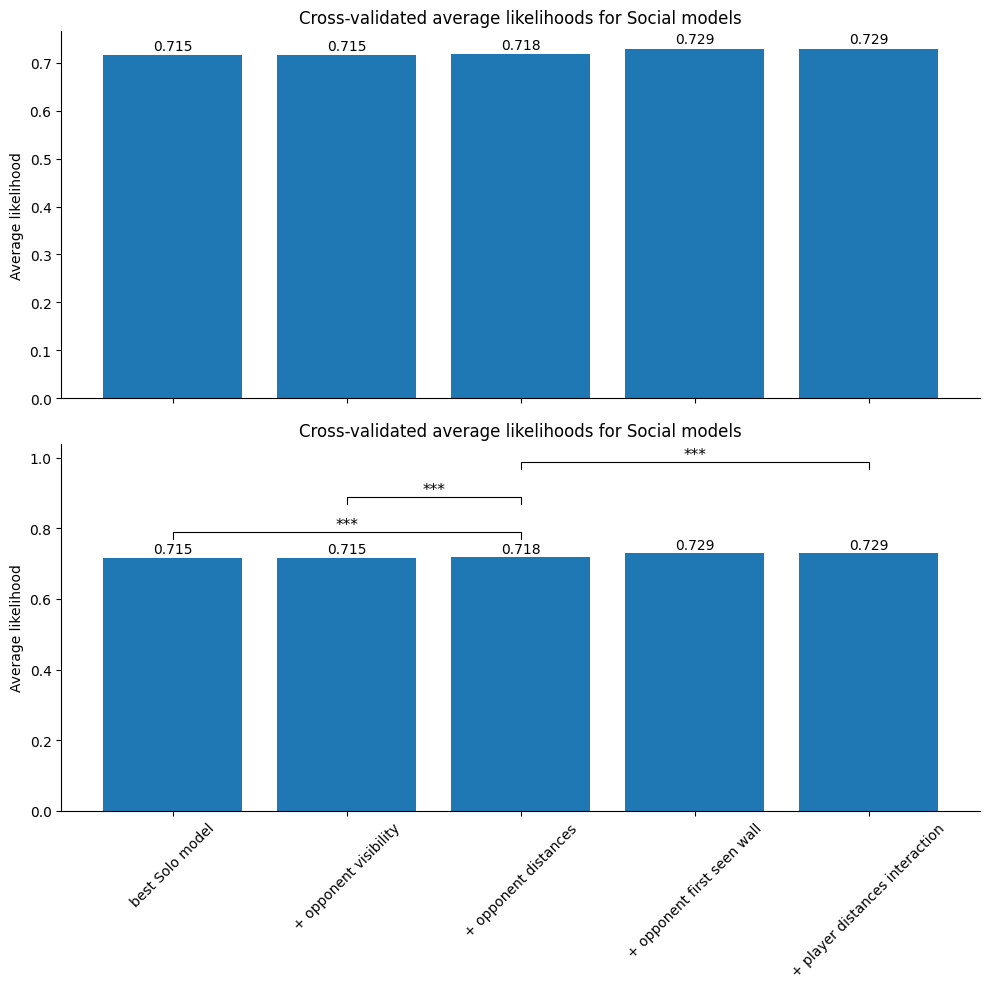

In [17]:
title1 = 'Cross-validated average likelihoods for Social models'
avg_model_likelihoods = [np.nanmean(np.concatenate(cross_validation_datasets[i]['fold_likelihoods'])) for i in range(len(cross_validation_datasets))]
results, filtered_pairs, bonferroni_alpha = run_pairwise_lrt(summed_nlls_per_model, model_complexities, alpha=0.05)
plot_likelihoods_with_significance(avg_model_likelihoods, summed_nlls_per_model, plotting_names, results, filtered_pairs, bonferroni_alpha, title1, title2=title1)

In [117]:
cross_validation_datasets[2]["model_formula"]

'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep  + OpponentD2H + OpponentD2L + (1|GlmPlayerID)'

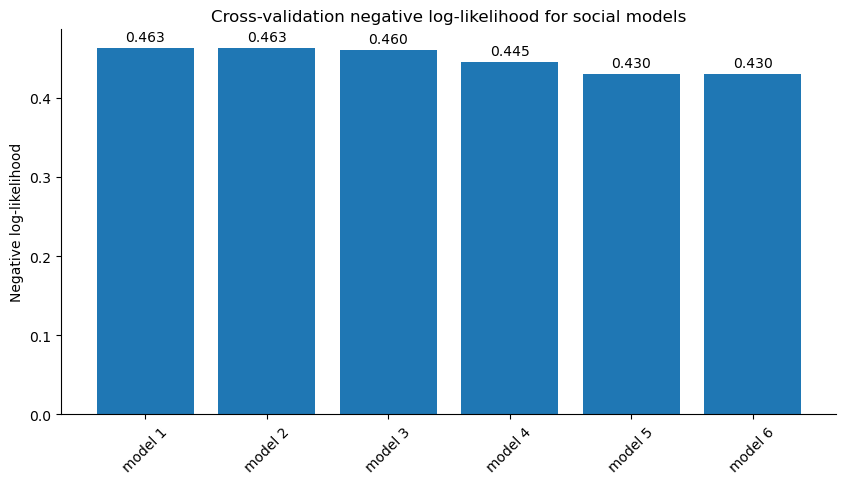

In [148]:
# plot nll barplot
plt.figure(figsize=(10, 5))
plt.bar(range(len(average_nlls)), average_nlls, tick_label=plotting_names)
plt.xticks(rotation=45)
plt.ylabel('Negative log-likelihood')
plt.title('Cross-validation negative log-likelihood for social models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add values above bars
for i, value in enumerate(average_nlls):
    plt.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()

In [149]:
cross_validation_datasets[1]["predict_data"][0].isna().sum()

SessionID                 0
PlayerID                  0
GlmPlayerID               0
ChooseHigh                0
WallSep                   0
FirstSeenWall             0
D2H                       0
D2L                       0
OpponentVisible           0
OpponentFirstSeenWall    85
OpponentD2H               0
OpponentD2L               0
dtype: int64

In [118]:
# get prediction and ground truth data for each of the models in cross_validation_datasets
prediction_data = [cross_validation_datasets[i]['predictions'] for i in range(len(cross_validation_datasets))]
ground_truth_data = [cross_validation_datasets[i]['predict_data'] for i in range(len(cross_validation_datasets))]


# concatenate across the folds to produce a single predictions and ground truth df for each model
for i, model_predictions in enumerate(prediction_data):
    prediction_data[i] = np.concatenate(model_predictions)

for i, model_ground_truth in enumerate(ground_truth_data):
    ground_truth_data[i] = np.concatenate(list(fold['ChooseHigh'].values for fold in model_ground_truth))




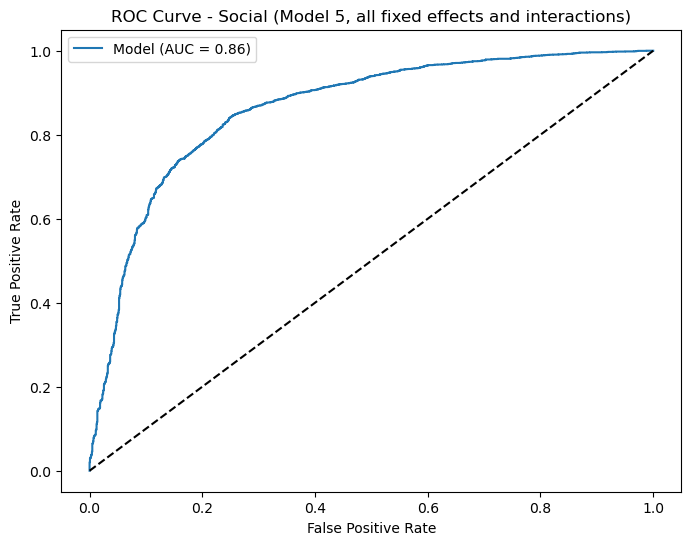

In [121]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming `y_true` is the true labels and `y_scores` are model predictions
fpr, tpr, _ = roc_curve(ground_truth_data[5], prediction_data[5])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Social (Model 5, all fixed effects and interactions)')
plt.legend()
plt.show()

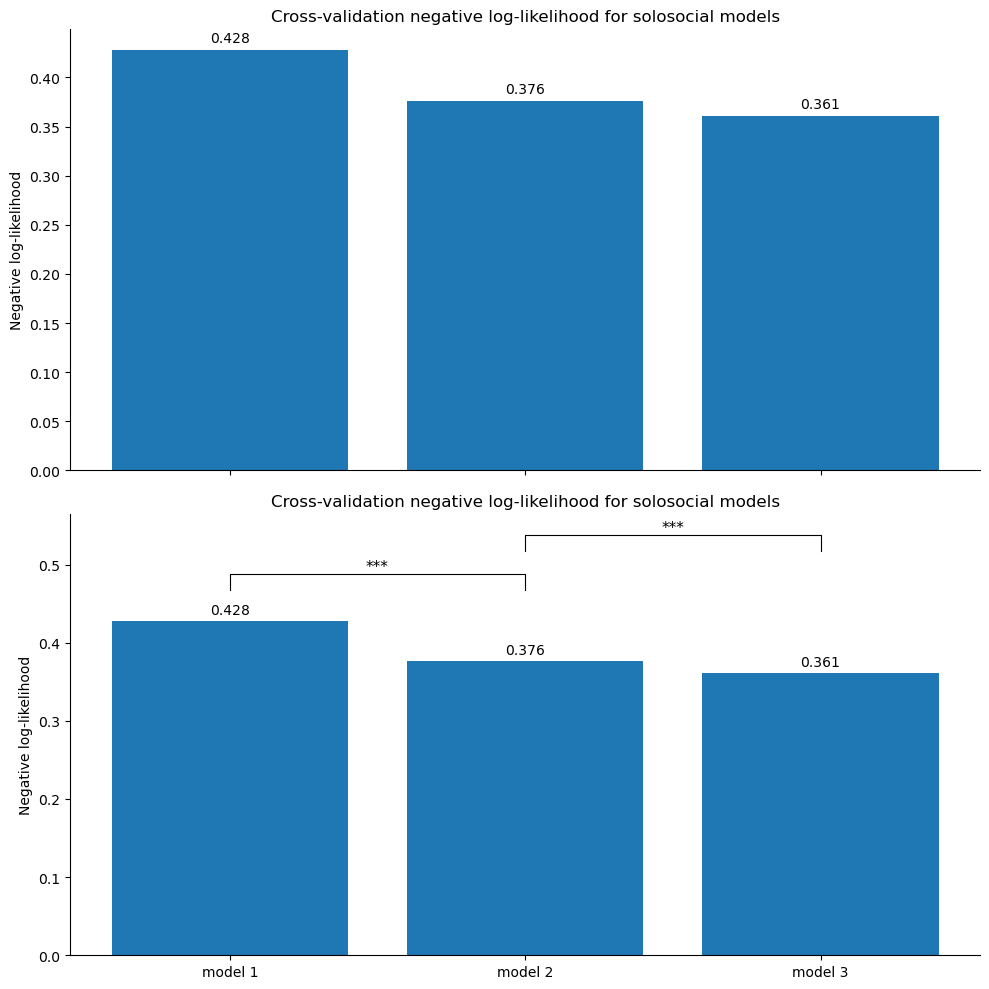

In [ ]:
# pairs = list(combinations(range(len(nlls)), 2))
# num_comparisons = len(pairs)
# # Bonferroni-corrected significance level
# bonferroni_alpha = 0.05 / num_comparisons
# title1 = 'Cross-validation negative log-likelihood for solosocial models'

# results, pairs, bonferroni_alpha = run_pairwise_ttests(nlls, alpha=0.05)
# plot_nlls_with_significance(average_nlls, plotting_names, results, pairs, bonferroni_alpha, title1, title2=title1)